In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
test = pd.read_csv('test_set_features.csv')
train = pd.read_csv('training_set_features.csv')
labels = pd.read_csv('training_set_labels.csv')
combine = pd.concat([train, test], axis = 0)
ID = combine['respondent_id']
labels = labels.drop(['respondent_id'], axis = 1)
combine = combine.drop(['respondent_id'], axis = 1)
full_train = pd.concat([labels, train], axis = 1)

In [4]:
combine.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
combine_cols = combine.columns
labels_cols = labels.columns

In [6]:
#check column names
print(combine_cols)
print(labels_cols)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')
Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')


In [7]:
#check the shape of the dataframes
print(train.shape)
print(test.shape)
print(labels.shape)
print(combine.shape)

(26707, 36)
(26708, 36)
(26707, 2)
(53415, 35)


In [8]:
#look at the response variables
labels.describe()

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [9]:
#26707 total rows
#21.2% got h1n1_vaccine
#46.6% got seasonal vaccine

In [10]:
combine.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,53238.000000,53177.000000,53265.000000,52994.000000,53377.000000,53333.000000,53256.000000,53251.000000,53159.000000,49095.000000,...,51822.000000,28913.000000,52626.000000,52647.000000,52645.000000,52501.000000,52402.000000,52357.000000,52941.000000,52941.000000
mean,1.620816,1.264287,0.049244,0.727705,0.069131,0.825849,0.355077,0.337271,0.680506,0.221489,...,0.111709,0.883824,3.847623,2.334701,2.359141,4.025409,2.713923,2.130756,0.890406,0.539166
std,0.906534,0.616881,0.216380,0.445145,0.253679,0.379243,0.478541,0.472783,0.466285,0.415253,...,0.315012,0.320442,1.007498,1.280608,1.361078,1.084875,1.380553,1.336077,0.753836,0.931626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [11]:
combine.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [12]:
all_data_na = (combine.isnull().sum()/len(combine))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(40)

,Missing Ratio
employment_occupation,0.503529
employment_industry,0.498081
health_insurance,0.458710
income_poverty,0.166994
doctor_recc_seasonal,0.080876
doctor_recc_h1n1,0.080876
rent_or_own,0.076346
employment_status,0.054928
marital_status,0.053356
education,0.052682


Text(0.5, 1.0, 'Percent missing data by feature')

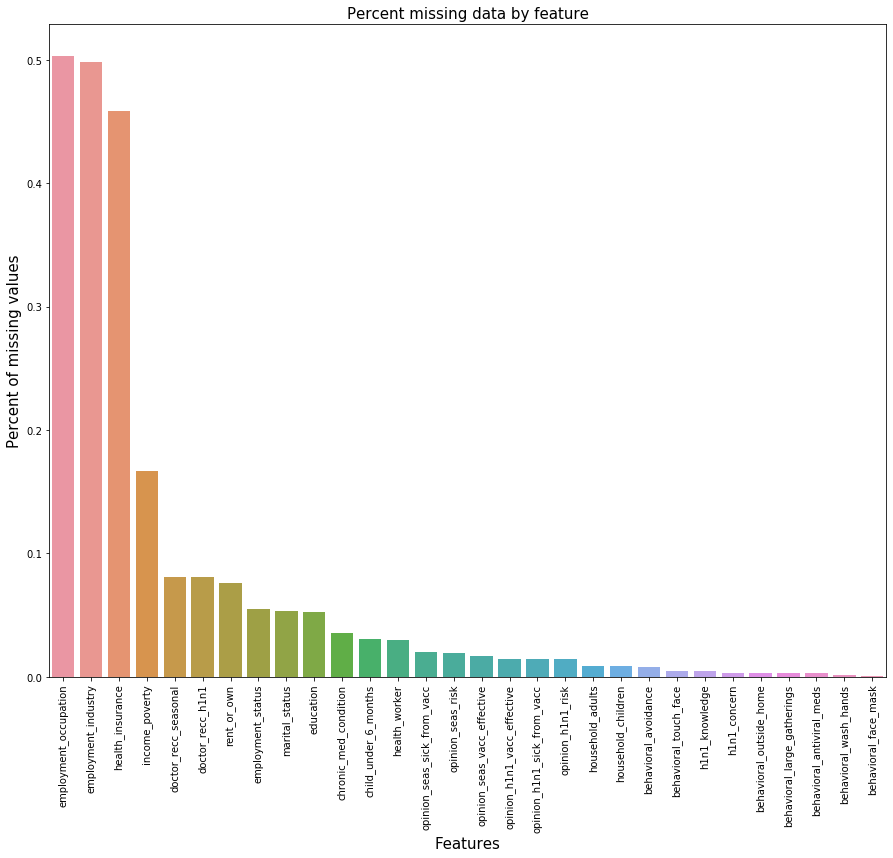

In [13]:
fig, ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [14]:
#anything with under 2% missing, just input the mode
cols = ('opinion_seas_sick_from_vacc',
        'opinion_seas_risk',
        'opinion_seas_vacc_effective',
        'opinion_h1n1_vacc_effective',
        'opinion_h1n1_sick_from_vacc',
        'opinion_h1n1_risk',
        'household_adults',
        'household_children',
        'behavioral_avoidance',
        'behavioral_touch_face',
        'h1n1_knowledge',
        'h1n1_concern',
        'behavioral_outside_home',
        'behavioral_large_gatherings',
        'behavioral_antiviral_meds',
        'behavioral_wash_hands',
        'behavioral_face_mask')

for c in cols:
    combine[c] = combine[c].fillna(combine[c].mode()[0])
    

In [15]:
#looks like empty cells for employement_occupation and employment_industry are due to being out of workforce. Will fill in
#with set code. Same for all. Will mean, not working.
combine['employment_occupation'] = combine['employment_occupation'].fillna('abcdefg')
combine['employment_industry'] = combine['employment_industry'].fillna('hijklm')

Text(0.5, 1.0, 'Percent missing data by feature')

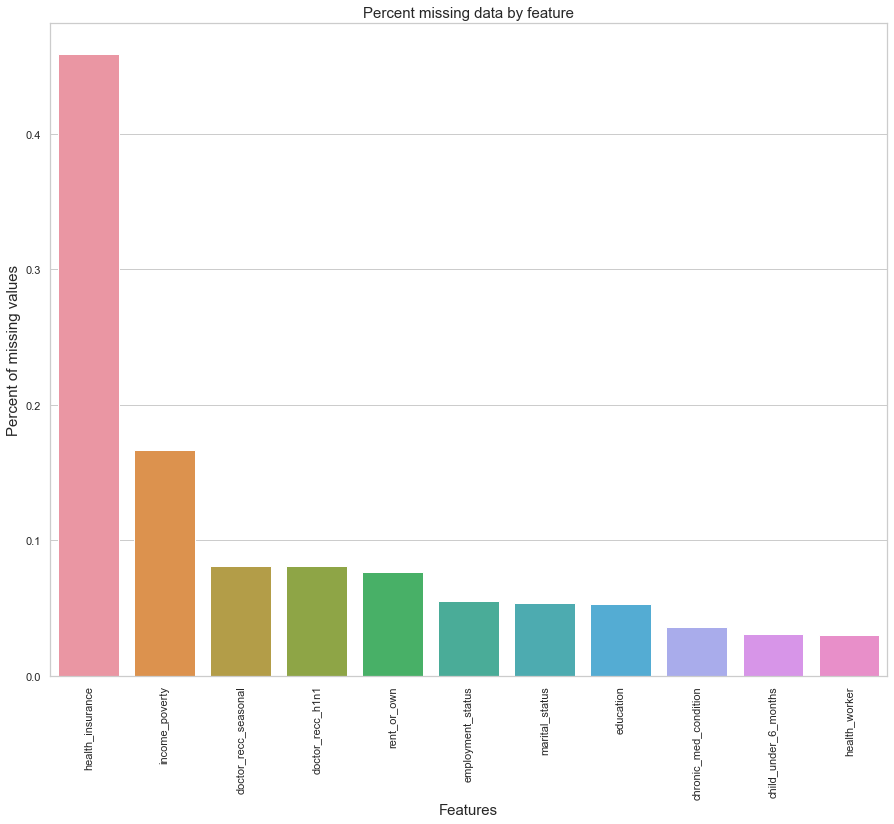

In [41]:
all_data_na = (combine.isnull().sum()/len(combine))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]

fig, ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

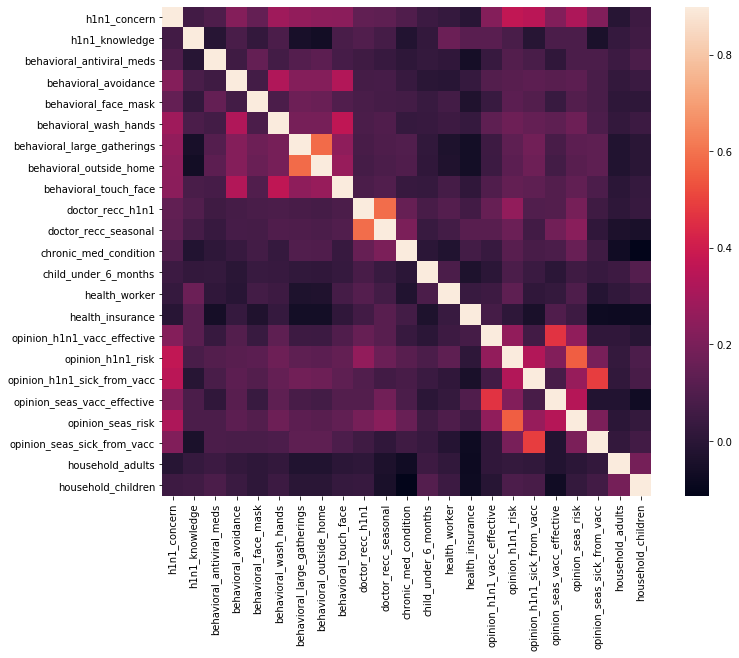

In [16]:
corrmat = combine.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [17]:
combine[['health_insurance', 'doctor_recc_seasonal']].groupby(['doctor_recc_seasonal'], as_index=False).mean().sort_values(by='doctor_recc_seasonal', ascending=False)

,doctor_recc_seasonal,health_insurance
1,1.0,0.935234
0,0.0,0.856206


In [18]:
combine[['health_insurance', 'doctor_recc_h1n1']].groupby(['doctor_recc_h1n1'], as_index=False).mean().sort_values(by='doctor_recc_h1n1', ascending=False)

,doctor_recc_h1n1,health_insurance
1,1.0,0.919402
0,0.0,0.871730


In [19]:
#impute the missing health_insurance values
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [20]:
#do logistic regression to fill values
y = combine['health_insurance']
X = combine.drop(['health_insurance'], axis = 1)

In [21]:
y.value_counts()

1.0    25554
0.0     3359
Name: health_insurance, dtype: int64

In [22]:
#pct with health_insurance
w_health = len(y[y==1])
wo_health = len(y[y==0])
pct_w = w_health / (w_health + wo_health)
print('percentage with health insurance: ', pct_w)

percentage with health insurance:  0.8838238854494518


Text(0, 0.5, 'health_care')

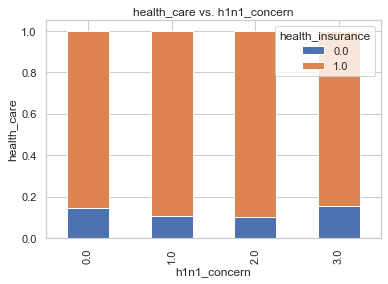

In [23]:
table = pd.crosstab(X.h1n1_concern,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. h1n1_concern')
plt.xlabel('h1n1_concern')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

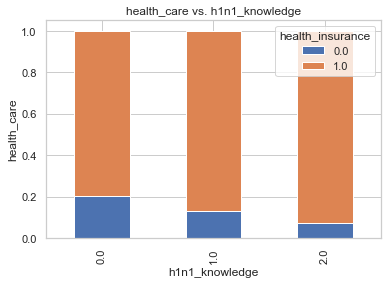

In [24]:
table = pd.crosstab(X.h1n1_knowledge,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. h1n1_knowledge')
plt.xlabel('h1n1_knowledge')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

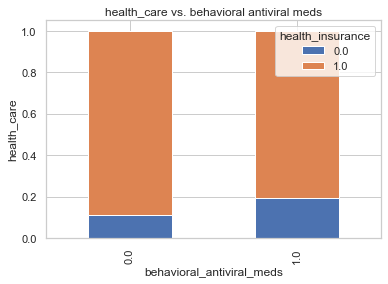

In [25]:
table = pd.crosstab(X.behavioral_antiviral_meds,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. behavioral antiviral meds')
plt.xlabel('behavioral_antiviral_meds')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

In [26]:
#presume that rest of behavioral variables are poor predictors of having health insurance

Text(0, 0.5, 'health_care')

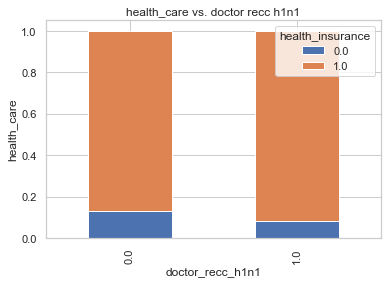

In [27]:
table = pd.crosstab(X.doctor_recc_h1n1,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. doctor recc h1n1')
plt.xlabel('doctor_recc_h1n1')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

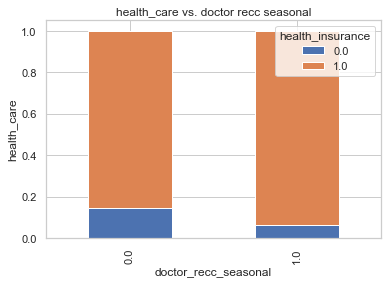

In [28]:
table = pd.crosstab(X.doctor_recc_seasonal,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. doctor recc seasonal')
plt.xlabel('doctor_recc_seasonal')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

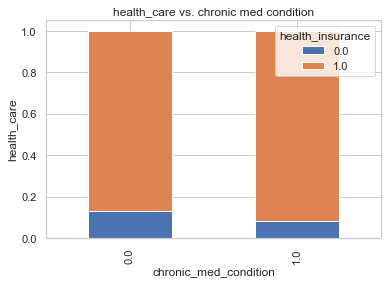

In [29]:
table = pd.crosstab(X.chronic_med_condition,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. chronic med condition')
plt.xlabel('chronic_med_condition')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

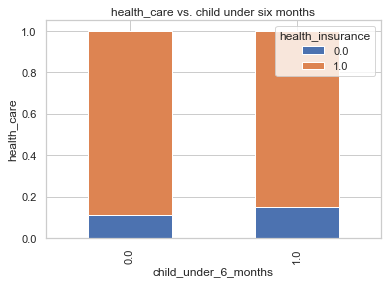

In [30]:
table = pd.crosstab(X.child_under_6_months,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. child under six months')
plt.xlabel('child_under_6_months')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

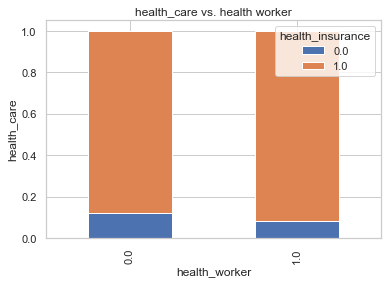

In [31]:
table = pd.crosstab(X.health_worker,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. health worker')
plt.xlabel('health_worker')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

In [32]:
#assume all opinion variables won't be predictors of health insurance

Text(0, 0.5, 'health_care')

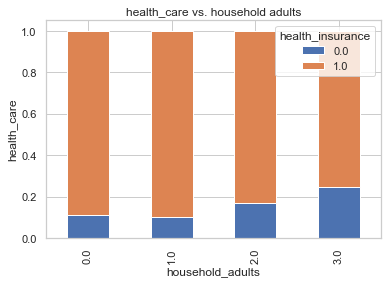

In [33]:
table = pd.crosstab(X.household_adults,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. household adults')
plt.xlabel('household_adults')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

Text(0, 0.5, 'health_care')

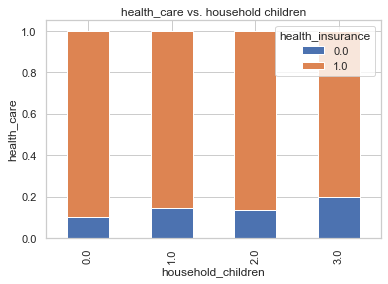

In [34]:
table = pd.crosstab(X.household_children,y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('health_care vs. household children')
plt.xlabel('household_children')
plt.ylabel('health_care')
#looks like a good predictor of health insurance

In [52]:
#predictors
cols = ['h1n1_concern','h1n1_knowledge','chronic_med_condition',
        'child_under_6_months', 'health_worker', 'household_adults', 'household_children', 
        'doctor_recc_sesasonal', 'doctor_recc_h1n1']

In [53]:
data_vars=X.columns.values.tolist()
to_keep=[i for i in data_vars if i in cols]

In [61]:
#final data for log regression
X = X[to_keep]
full_data = pd.concat([y, X], axis = 1)
full_data = full_data.dropna()


ValueError: Shape of passed values is (55421, 8), indices imply (40101, 8)

In [62]:
y = full_data['health_insurance']
X = full_data.drop(['health_insurance'], axis = 1)

In [67]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True]
[1 1 1 1 1 1 1]


C:\Users\ericp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [68]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.359813
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  -0.002    
Dependent Variable:   health_insurance  AIC:               20620.4719
Date:                 2021-02-17 21:44  BIC:               20678.3086
No. Observations:     28635             Log-Likelihood:    -10303.   
Df Model:             6                 LL-Null:           -10279.   
Df Residuals:         28628             LLR p-value:       1.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
h1n1_concern           0.2933   0.0172 17.0804 0.0000  0.2596  0.3269
h1n1_knowledge  

In [69]:
#household_adults has p-value over 0.05. we'll remove it.
X = X.drop(['household_adults'], axis = 1)

In [70]:
#rerun model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.359814
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  -0.002    
Dependent Variable:   health_insurance  AIC:               20618.5509
Date:                 2021-02-17 21:48  BIC:               20668.1252
No. Observations:     28635             Log-Likelihood:    -10303.   
Df Model:             5                 LL-Null:           -10279.   
Df Residuals:         28629             LLR p-value:       1.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
h1n1_concern           0.2944   0.0167 17.6574 0.0000  0.2617  0.3271
h1n1_knowledge  